In [1]:
import pandas as pd
import json
import requests
import time
from typing import Dict, List
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import userdata
key = userdata.get('OPENROUTER_API_KEY')

In [4]:
df = pd.read_csv('yelp.csv')

In [5]:
df.columns

Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny'],
      dtype='object')

In [6]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2.0,5.0,0.0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0.0,0.0,0.0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0.0,1.0,0.0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1.0,2.0,0.0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0.0,0.0,0.0


In [7]:
# sampling 40 data for each stars 1-5, So 5*40=200
sample_df = df.groupby('stars', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 40))
).reset_index(drop=True)

/tmp/ipython-input-593445460.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('stars', group_keys=False).apply(


In [8]:
print(f"Sampled {len(sample_df)} reviews")
print(sample_df['stars'].value_counts().sort_index())

Sampled 200 reviews
stars
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64


In [14]:
def model_call(prompt, sys_prompt):
  try:
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {key}",
            "Content-Type": "application/json",
        },
        data=json.dumps({
            "model": "xiaomi/mimo-v2-flash:free",
            "messages": [
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
                ],
            "temperature": 0.1,
            "reasoning": {"enabled": True}
            })
        )
    response.raise_for_status()
    return response.json()
  except Exception as e:
    print(f"API ERRORL {e}")
    return None


**APPROACH 1 - Direct-Method:**
   - Design: Simple, straightforward instruction
   - Rationale: Minimal complexity, direct task specification
   - Expected Strengths: Fast, consistent JSON format
   - Expected Weaknesses: May lack nuanced understanding





In [15]:
def approach1(review_text):
  sys_prompt = """You are a rating prediction system.
  Analyze reviews and predict star ratings from 1 to 5.
  Always respond with valid JSON only, no other text.
  Format: {"predicted_stars": <number>, "explanation": "<reason>"}"""
  user_prompt = f"""Review: {review_text}
  Predict the star rating (1-5) for this review. Return only JSON."""
  return model_call(user_prompt, sys_prompt)

In [16]:
# TEST
approach1(sample_df.loc[0, 'text'])

{'id': 'gen-1767900892-Pq6vI5M3SoYZAtwzluGr',
 'provider': 'Xiaomi',
 'model': 'xiaomi/mimo-v2-flash:free',
 'object': 'chat.completion',
 'created': 1767900892,
 'choices': [{'logprobs': None,
   'finish_reason': 'stop',
   'native_finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': '{"predicted_stars": 1, "explanation": "The review expresses extreme dissatisfaction, citing a foul salad bar, dark and dirty environment, lack of customers, and overall disgust, with the reviewer stating they would give no stars if possible."}',
    'refusal': None,
    'reasoning': 'First, the user wants me to predict the star rating from 1 to 5 based on the review. I need to analyze the review and output only JSON in the format: {"predicted_stars": <number>, "explanation": "<reason>"}.\n\nThe review is very negative. Let me break down the key points:\n\n- The reviewer says they would give no stars if possible, which implies a very low rating.\n\n- They mention that 

**APPROACH 2 - Sentiment Analysis Method:**
   - Design: Structured reasoning with explicit sentiment mapping
   - Rationale: Guides model through analytical process
   - Expected Strengths: Better reasoning, more accurate predictions
   - Expected Weaknesses: More verbose, potential JSON format issues

In [17]:
def approach2(review_text):
  sys_prompt = """You are an expert sentiment analyzer for business reviews.
  Follow this process:
  1. Identify positive and negative aspects
  2. Assess overall sentiment intensity
  3. Map to star rating:
    - 5 stars: Extremely positive, enthusiastic
    - 4 stars: Positive with minor issues
    - 3 stars: Mixed or neutral feelings
    - 2 stars: Mostly negative with few positives
    - 1 star: Extremely negative, angry

  Respond only with valid JSON: {"predicted_stars": <number>, "explanation": "<reason>"}"""
  user_prompt = f"""Analyze this review and predict the rating: "{review_text}"
  First analyze the sentiment, then predict the start rating(1-5)."""

  return model_call(user_prompt, sys_prompt)

In [18]:
# TEST
approach2(sample_df.loc[0, 'text'])

{'id': 'gen-1767900903-kx1elmmtYmbIad10Et1h',
 'provider': 'Xiaomi',
 'model': 'xiaomi/mimo-v2-flash:free',
 'object': 'chat.completion',
 'created': 1767900903,
 'choices': [{'logprobs': None,
   'finish_reason': 'stop',
   'native_finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': '{"predicted_stars": 1, "explanation": "The review is extremely negative, with the reviewer expressing a desire to give zero stars, describing the salad bar as \'foul\' and a \'brown mess,\' the place as dark, dirty, and empty, and questioning how it survives while better establishments close. There are no positive aspects mentioned, indicating intense dissatisfaction."}',
    'refusal': None,
    'reasoning': 'First, I need to analyze the sentiment of the review. The user wants me to identify positive and negative aspects, assess overall sentiment intensity, and then map it to a star rating from 1 to 5.\n\nLet me read the review carefully:\n\n- "this another place tha

**APPROACH 3 - Few-Shot Method:**
   - Design: Provides 5 examples covering all rating levels
   - Rationale: Learning by example, pattern recognition
   - Expected Strengths: Better calibration, consistent scale usage
   - Expected Weaknesses: Longer prompts, higher token usage



In [19]:
def approach3(review_text):
  sys_prompt = """You are a rating prediction expert.
  Learn from the examples and predict rating for new reviews.
  Always return valid JSON only."""

  user_prompt = f"""Predict the rating for this review: "{review_text}"
  Using the following examples:
  1. Review: "Absolutely amazing! Best service ever, food was delicious!" -> 5 stars
  2. Review: "Pretty good overall, service was nice but food was a bit cold." → 4 stars
  3. Review: "It was okay, nothing special but not bad either." → 3 stars
  4. Review: "Disappointing experience, slow service and cold food." → 2 stars
  5. Review: "Terrible! Worst experience ever, will never return!" → 1 star

  Return only valid JSON: {{"predicted_stars": <number>, "explanation": "<reason>"}}."""

  return model_call(user_prompt, sys_prompt)

In [20]:
# TEST
approach3(sample_df.loc[0, 'text'])

{'id': 'gen-1767900912-mxnHEl2Vlm7n8BwKl8Gx',
 'provider': 'Xiaomi',
 'model': 'xiaomi/mimo-v2-flash:free',
 'object': 'chat.completion',
 'created': 1767900912,
 'choices': [{'logprobs': None,
   'finish_reason': 'stop',
   'native_finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': '{"predicted_stars": 1, "explanation": "The review expresses extreme dissatisfaction, describing the restaurant as having a foul salad bar, being dark and dirty, with no customers, and the user would give no stars if possible. This aligns with the 1-star example of a terrible experience with no intention to return."}',
    'refusal': None,
    'reasoning': 'First, I am considering the task: I need to predict the rating for a given review based on the examples provided. The review is about a restaurant, and it\'s very negative. The user describes it as having a foul salad bar, being dark and dirty, and no one inside. They also express disbelief that it survives while be

In [21]:
def extract(response):
  if not response:
    return {"predicted_stars": None,
            "explanation": "API Error",
            "valid_json": False
            }
  try:
    content = response['choices'][0]['message']['content']
    content = content.strip()
    result = json.loads(content)
    stars = result.get('predicted_stars')
    if stars and 1 <= stars <= 5:
      result['valid_json'] = True
      return result
    else:
      result['valid_json'] = False
      return {"predicted_stars": None,
              "explanation": "Invalid rating range",
              "valid_json": False
              }
  except json.JSONDecodeError:
    return {"predicted_stars": None, "explanation": f"JSON Parse Error: {content[:100]}", "valid_json": False}

  except Exception as e:
    return {"predicted_stars": None, "explanation": f"Error: {str(e)}", "valid_json": False}


In [29]:
# test
result = extract(approach3(sample_df.loc[0, 'text']))
print(result)

{'predicted_stars': 1, 'explanation': "The review expresses extreme dissatisfaction, describing the establishment as having a 'foul salad bar,' being 'dark and dirty,' and having 'no one inside,' with the reviewer stating they would give 'no stars if possible,' which aligns with a 1-star rating based on the examples provided.", 'valid_json': True}


In [23]:
def evaluate(df, approah_func):
  results = []
  for idx, row in df.iterrows():
    review_text = row['text']
    stars = row['stars']

    model_response = approah_func(review_text)
    prediction = extract(model_response)
    results.append({
        'review_text': review_text,
        'actual_stars': stars,
        'predicted_stars': prediction['predicted_stars'],
        'explanation': prediction['explanation'],
        'valid_json': prediction['valid_json'],
        'correct': prediction['predicted_stars'] == stars if prediction['predicted_stars'] else False,
    })

    time.sleep(1)
  print('\nDONE....')
  return pd.DataFrame(results)

In [24]:
results_approach1 = evaluate(sample_df, approach1)


DONE....


In [25]:
results_approach1.to_csv('approach1_results.csv', index=False)

In [26]:
results_approach2 = evaluate(sample_df, approach2)


DONE....


In [27]:
results_approach2.to_csv('approach2_results.csv', index=False)

In [30]:
results_approach3 = evaluate(sample_df, approach3)


DONE....


In [31]:
results_approach3.to_csv('approach3_results.csv', index=False)

In [32]:
def calc_metrics(results, approach_name):
  valid_predictions = results[results['valid_json'] == True]
  accuracy = valid_predictions['correct'].mean()
  json_validity = results['valid_json'].mean()
  mae = np.abs(valid_predictions['predicted_stars'] - valid_predictions['actual_stars']).mean()
  metrics = {
      'Approach': approach_name,
      'Accuracy(%)': f"{accuracy*100:.2f}",
      'Json Validity(%)': f"{json_validity*100:.2f}",
      'Mean Absolute Error': f"{mae:.2f}",
      'Total Predictions': len(results),
      'Valid Predictions': len(valid_predictions)
  }
  return metrics

In [33]:
metrics1 = calc_metrics(results_approach1, 'Approach1')
metrics2 = calc_metrics(results_approach2, 'Approach2')
metrics3 = calc_metrics(results_approach3, 'Approach3')

In [34]:
compare_df = pd.DataFrame([metrics1, metrics2, metrics3])
print(compare_df.to_string(index=False))

 Approach Accuracy(%) Json Validity(%) Mean Absolute Error  Total Predictions  Valid Predictions
Approach1       61.50           100.00                0.40                200                200
Approach2       62.00           100.00                0.41                200                200
Approach3       64.82            99.50                0.38                200                199


In [35]:
from sklearn.metrics import confusion_matrix

In [40]:
def plot(metrics1, metrics2, metrics3):
  fig, axes = plt.subplots(2, 2, figsize=(15, 12))
  approaches = ['Approach1', 'Approach2', 'Approach3']
  accuracies = [float(metrics1['Accuracy(%)']),
                float(metrics2['Accuracy(%)']),
                float(metrics3['Accuracy(%)'])]
  axes[0, 0].bar(approaches, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'])
  axes[0, 0].set_title('Accuracy Comparison')
  axes[0, 0].set_ylabel('Accuracy (%)')
  axes[0, 0].set_ylim(0, 100)

  json_validities = [float(metrics1['Json Validity(%)']),
                     float(metrics2['Json Validity(%)']),
                     float(metrics3['Json Validity(%)'])]
  axes[0, 1].bar(approaches, json_validities, color=['#3498db', '#e74c3c', '#2ecc71'])
  axes[0, 1].set_title('Json Validity Comparison')
  axes[0, 1].set_ylabel('Json Validity (%)')
  axes[0, 1].set_ylim(0, 100)

  best_results = results_approach1
  valid_preds = best_results[best_results['correct'] == True]
  cm = confusion_matrix(valid_preds['actual_stars'], valid_preds['predicted_stars'])

  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
              xticklabels=[1,2,3,4,5])
  axes[1, 0].set_title('Confusion Matrix')
  axes[1, 0].set_xlabel('Predicted Stars')
  axes[1, 0].set_ylabel('Actual Stars')


  mae_vals = [float(metrics1['Mean Absolute Error']),
              float(metrics2['Mean Absolute Error']),
              float(metrics3['Mean Absolute Error'])]
  axes[1, 1].bar(approaches, mae_vals, color=['#3498db', '#e74c3c', '#2ecc71'])
  axes[1, 1].set_title('Mean Absolute Error Comparison')
  axes[1, 1].set_ylabel('Mean Absolute Error')

  plt.tight_layout()
  plt.savefig('yelp_rating_comparion.png', dpi=300, bbox_inches='tight')
  plt.show()

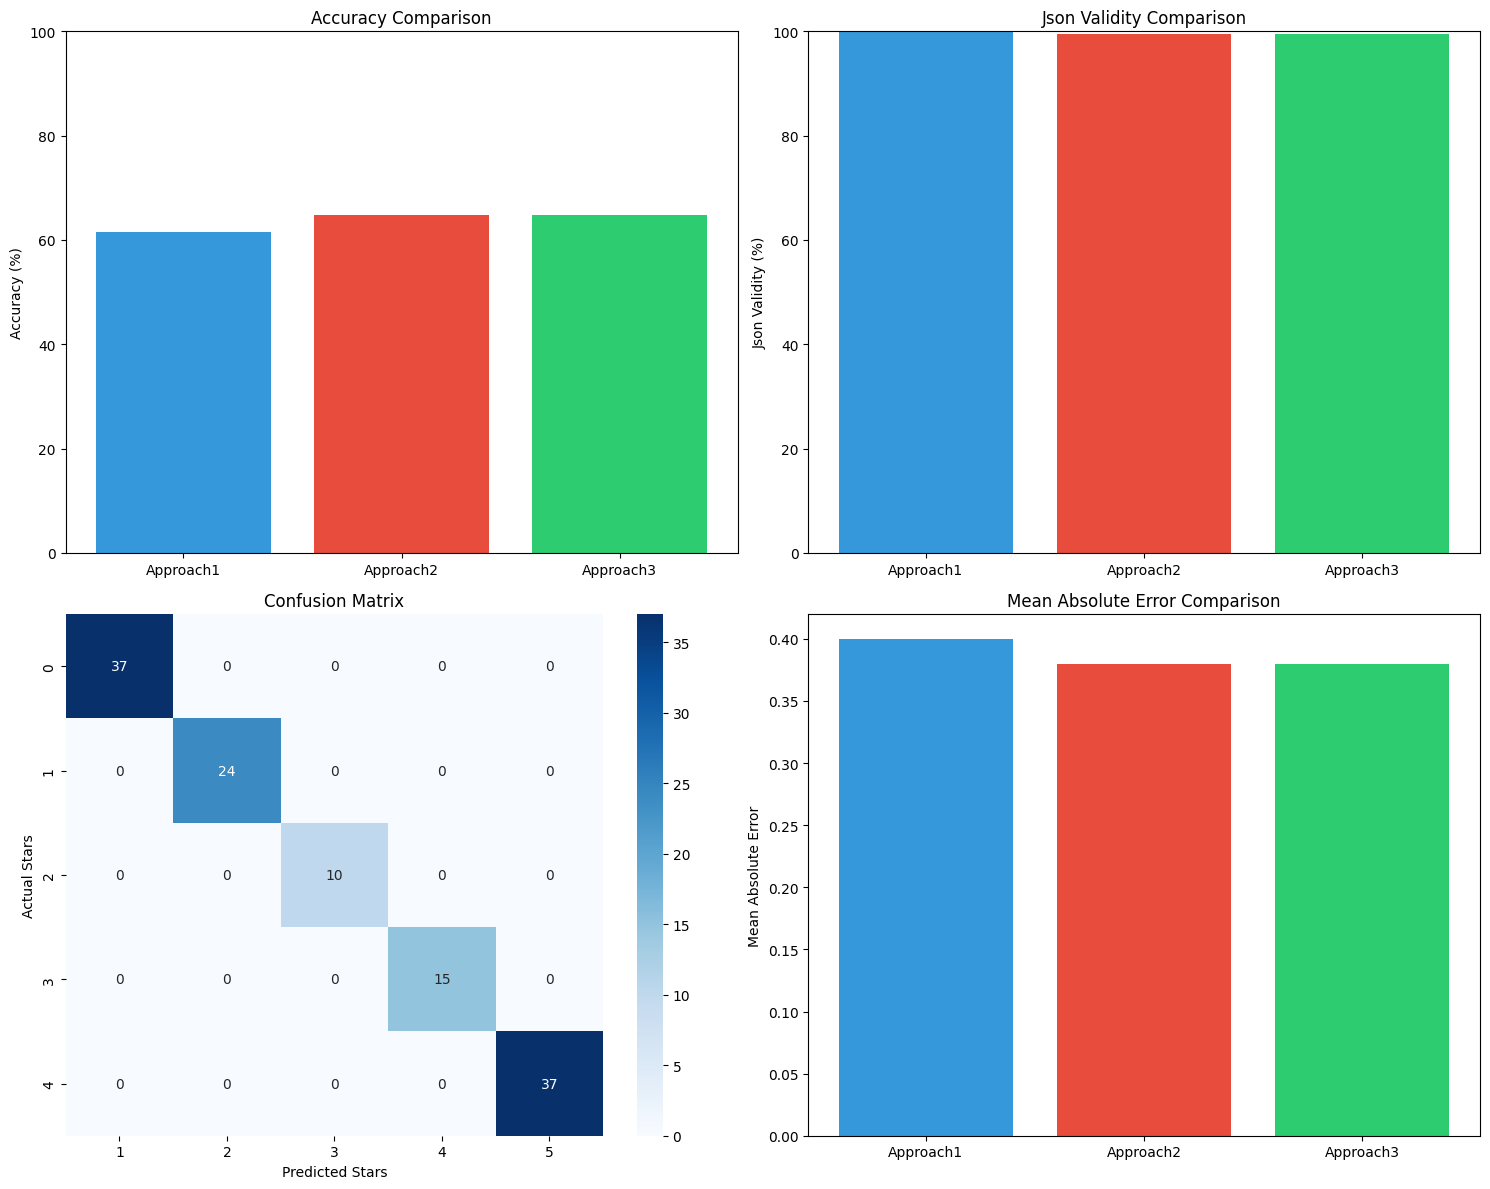

In [41]:
plot(metrics1, metrics3, metrics3)

Well not surprsing that the Approach-3 has the highest accuracy. The more detail information you give to the LLM, the better it performs it's been proved by serveral papers.

In [42]:
compare_df.to_csv('comparison_metrics.csv', index=False)